In [99]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import datetime
from landaupy.landaupy import landau
from scipy.optimize import curve_fit
from scipy.stats import chisquare

In [100]:
df = pl.read_csv("data/S_integral.csv")
df

S,Integral_S
f64,f64
6.9035e-10,7.1100e-10
1.1879e-9,1.1946e-9
5.9585e-10,6.1835e-10
6.4474e-10,6.5647e-10
5.6275e-10,5.6998e-10
…,…
8.1029e-10,7.7580e-10
7.5974e-10,7.1109e-10
5.7243e-10,5.4239e-10


In [101]:
hist = np.histogram(df["Integral_S"], bins=200)
x = hist[1][:-1]
# x = x/sum(x)
y = hist[0]

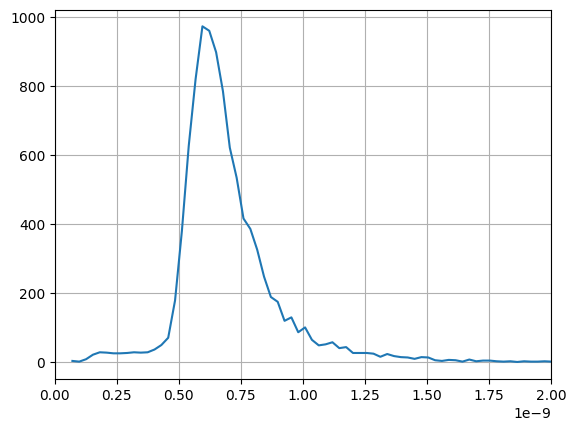

In [102]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlim(0, 2e-9)
ax.grid()

In [103]:
def fit_function(x, x_mpv, xi, A):
    return A*landau.pdf(x, x_mpv, xi)

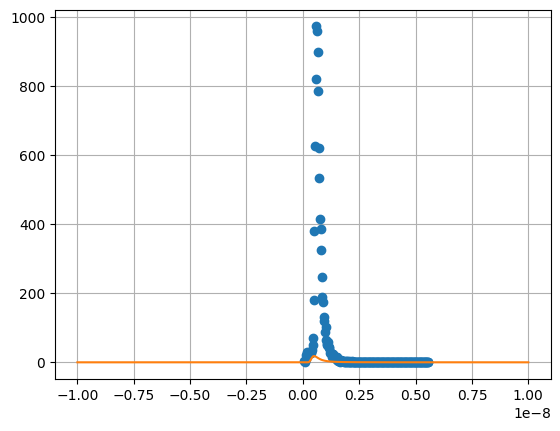

In [104]:
init_params = [0.5e-9, 1e-10, 1e-8]

x_test = np.linspace(-1e-8, 1e-8, 1000)
y_test = fit_function(x_test, *init_params)

fig, ax = plt.subplots()
ax.plot(x, y, "o")
ax.plot(x_test, y_test)
ax.grid()

In [105]:
popt, pcov = curve_fit(fit_function, x, y, p0=init_params, maxfev=10000)
popt

array([5.99296085e-10, 5.47012098e-11, 2.93482792e-07])

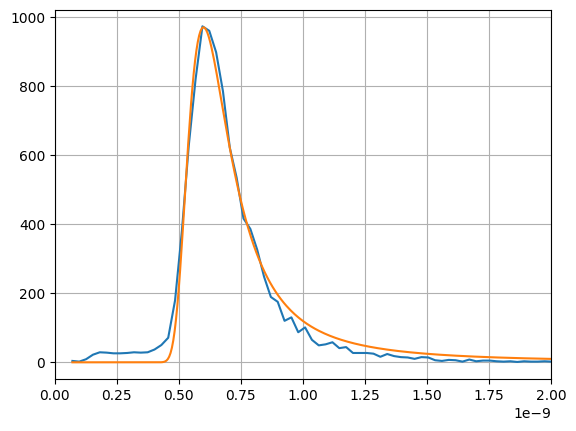

In [106]:
fig, ax = plt.subplots()
ax.plot(x, y)

fit_x = np.linspace(x.min(), x.max(), 1000)
ax.plot(fit_x, fit_function(fit_x, *popt))
ax.set_xlim(0, 2e-9) # 微調整用
ax.grid()
plt.show()

ある時間でカットを行う

In [107]:
len(x)

200

In [108]:
len(y)

200

In [109]:
range_x = [0.5e-9, 0.8e-9]
rx = x[(x > range_x[0]) & (x < range_x[1])]
ry = y[(x > range_x[0]) & (x < range_x[1])]

rpopt, rpcov = curve_fit(fit_function, rx, ry, p0=init_params, maxfev=10000)
rpopt

array([6.02781815e-10, 5.67703447e-11, 3.03181536e-07])

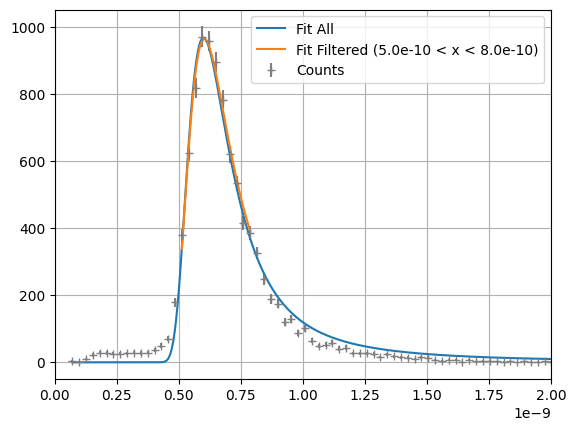

In [110]:
rfit_x = np.linspace(rx.min(), rx.max(), 1000)
fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=np.sqrt(y), fmt="+", label="Counts", color="gray")
ax.plot(fit_x, fit_function(fit_x, *popt), label="Fit All")
ax.plot(rfit_x, fit_function(rfit_x, *rpopt), label=f"Fit Filtered ({range_x[0]:.1e} < x < {range_x[1]:.1e})")
ax.grid()
ax.set_xlim(0, 2e-9)
ax.legend()

fig.savefig(f"images/MIP_{datetime.datetime.today()}.png")

plt.show()

In [111]:
x_mpv , xi, A = popt
x_mpv_std, xi_std, A_std = np.sqrt(np.diag(pcov))

print(f"x_mpv = {x_mpv:.2e} +- {x_mpv_std:.2e}")
print(f"xi = {xi:.2e} +- {xi_std:.2e}")
print(f"A = {A:.2e} +- {A_std:.2e}")

x_mpv = 5.99e-10 +- 9.17e-13
xi = 5.47e-11 +- 6.59e-13
A = 2.93e-07 +- 2.69e-09


In [112]:
def chi2(x, y, *params):
    # 期待値は同じにならないといけない
    obs_sum = np.sum(y)
    exp_sum = np.sum(fit_function(x, *params))
    print(f"Observed sum: {obs_sum}, Expected sum: {exp_sum}")
    
    # スケールを合わせる
    expected_scaled = fit_function(x, *params) * (np.sum(y) / np.sum(fit_function(x, *params)))
    scaled_sum = np.sum(expected_scaled)
    print(f"Scaled Expected sum: {scaled_sum}")
    
    chi2, p = chisquare(y, expected_scaled)
    print(f"chi2: {chi2}, p: {p}")
    print(f"chi2/ndf: {chi2}/{len(x)-len(params)}")
    print(f"chi2/ndf: {chi2/(len(x)-len(params))}")

In [113]:
chi2(rx, ry, *rpopt)

Observed sum: 7394, Expected sum: 7405.436942963775
Scaled Expected sum: 7393.999999999999
chi2: 17.134311710374064, p: 0.07144433498940145
chi2/ndf: 17.134311710374064/8
chi2/ndf: 2.141788963796758


In [114]:
chi2(x, y, *popt)

Observed sum: 10000, Expected sum: 10513.053495767917
Scaled Expected sum: 10000.0
chi2: inf, p: 0.0
chi2/ndf: inf/197
chi2/ndf: inf


/home/jijinbei/lab/Vplot/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:7652: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
